# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,BatchNormalization,MaxPooling2D,Conv2DTranspose,Activation,Input,Concatenate
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Add, DepthwiseConv2D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2


# Generate and preprocess data

In [2]:
img_size=200
batch_size=32

train='Training Image sp 23'
test='Test Image sp 23'

datagen=ImageDataGenerator(rescale=1/255.,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           validation_split=0.2,
                           rotation_range=20,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.2,
                           fill_mode='nearest')

train_dataset=datagen.flow_from_directory(train,
                                       target_size=(img_size,img_size),
                                       batch_size=batch_size,
                                       shuffle=True,
                                       class_mode='categorical',
                                       subset='training')
test_dataset=datagen.flow_from_directory(test,
                                      shuffle=False,
                                      batch_size=batch_size,
                                      target_size=(img_size,img_size),
                                      class_mode="categorical")

validation_dataset=datagen.flow_from_directory(train,
                                    shuffle=False,
                                    batch_size=batch_size,
                                    target_size=(img_size,img_size),
                                    class_mode='categorical',
                                    subset='validation')

Found 1475 images belonging to 16 classes.
Found 480 images belonging to 16 classes.
Found 363 images belonging to 16 classes.


# Change the Test dataset image format to match with the image_sample_output.csv

Note: This code should only run once, when the data is processed already (as the test data I submitted), it will show errors.

In [3]:
"""
def rename_files_in_folder(path):
    for filename in os.listdir(path):
        # Check if the filename matches the old pattern
        if "test_" in filename and (filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg")):
            # Extract the label and number
            label, number = filename.split(" (")
            number, ext = os.path.splitext(number)
            number = number.replace(")", "")

            # Create a new filename using the new pattern
            new_filename = f"{label}_{number}{ext}"

            # Rename the file
            os.rename(os.path.join(path, filename), os.path.join(path, new_filename))

# Set the path to the main test dataset folder
main_path = test

# Iterate through all subfolders in the main folder
for subdir in os.listdir(main_path):
    subdir_path = os.path.join(main_path, subdir)

    if os.path.isdir(subdir_path):
        rename_files_in_folder(subdir_path)

print("Filenames have been updated.")

"""


'\ndef rename_files_in_folder(path):\n    for filename in os.listdir(path):\n        # Check if the filename matches the old pattern\n        if "test_" in filename and (filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg")):\n            # Extract the label and number\n            label, number = filename.split(" (")\n            number, ext = os.path.splitext(number)\n            number = number.replace(")", "")\n\n            # Create a new filename using the new pattern\n            new_filename = f"{label}_{number}{ext}"\n\n            # Rename the file\n            os.rename(os.path.join(path, filename), os.path.join(path, new_filename))\n\n# Set the path to the main test dataset folder\nmain_path = test\n\n# Iterate through all subfolders in the main folder\nfor subdir in os.listdir(main_path):\n    subdir_path = os.path.join(main_path, subdir)\n\n    if os.path.isdir(subdir_path):\n        rename_files_in_folder(subdir_path)\n\nprint("Filenames ha

## Show some preprocessed images with its labels

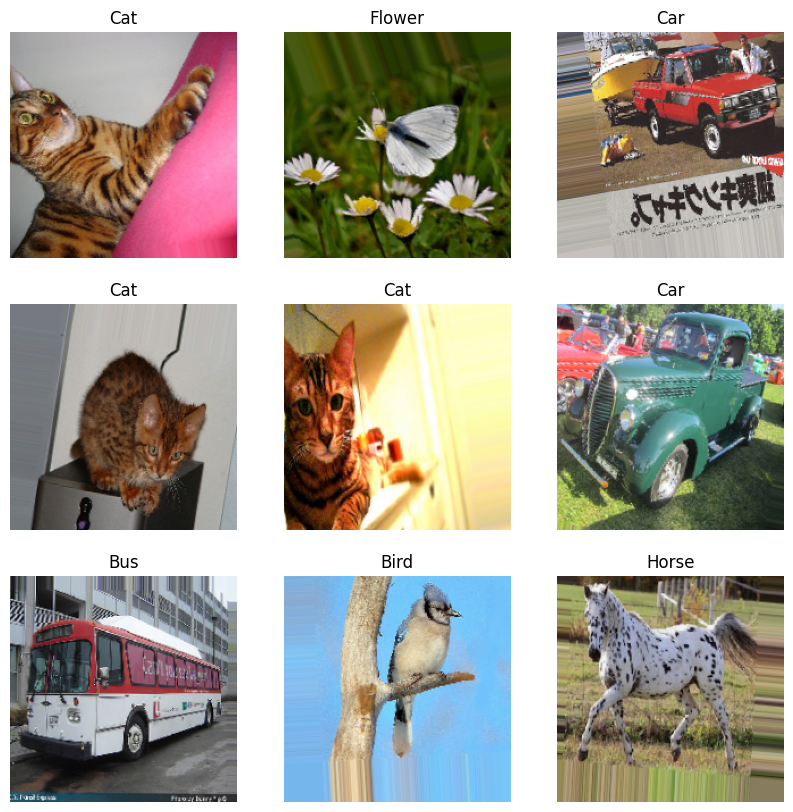

In [4]:
# Get a batch of images and labels
images, labels = next(train_dataset)

class_labels = {v: k for k, v in train_dataset.class_indices.items()}

# Plot the images with their labels
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[np.argmax(labels[i])])
    plt.axis("off")

In [5]:
class_labels.values()

dict_values(['Adult', 'Airplane', 'Alpaca', 'Bird', 'Bus', 'Car', 'Cat', 'Child', 'Elephant', 'Flower', 'Giraffe', 'Horse', 'Monkey', 'Panda', 'Reptile', 'Vessel'])

# Build and train model

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='softmax')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, mode= 'max')
history = model.fit(train_dataset,epochs=10,validation_data=validation_dataset,callbacks=callback)

Epoch 1/10


2023-05-01 17:42:57.375776: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


47/47 [==============================] - 32s 676ms/step - loss: 2.7580 - accuracy: 0.0827 - val_loss: 2.6797 - val_accuracy: 0.1240
Epoch 2/10
47/47 [==============================] - 35s 736ms/step - loss: 2.6444 - accuracy: 0.1186 - val_loss: 2.6142 - val_accuracy: 0.1240
Epoch 3/10
47/47 [==============================] - 35s 740ms/step - loss: 2.5386 - accuracy: 0.1817 - val_loss: 2.4814 - val_accuracy: 0.2066
Epoch 4/10
47/47 [==============================] - 36s 757ms/step - loss: 2.3912 - accuracy: 0.2054 - val_loss: 2.4113 - val_accuracy: 0.1956
Epoch 5/10
47/47 [==============================] - 36s 744ms/step - loss: 2.3150 - accuracy: 0.2434 - val_loss: 2.2611 - val_accuracy: 0.2645
Epoch 6/10
47/47 [==============================] - 30s 632ms/step - loss: 2.2863 - accuracy: 0.2454 - val_loss: 2.2964 - val_accuracy: 0.2397
Epoch 7/10
47/47 [==============================] - 37s 782ms/step - loss: 2.1593 - accuracy: 0.2725 - val_loss: 2.2556 - val_accuracy: 0.2837
Epoch 8/10

# Show results

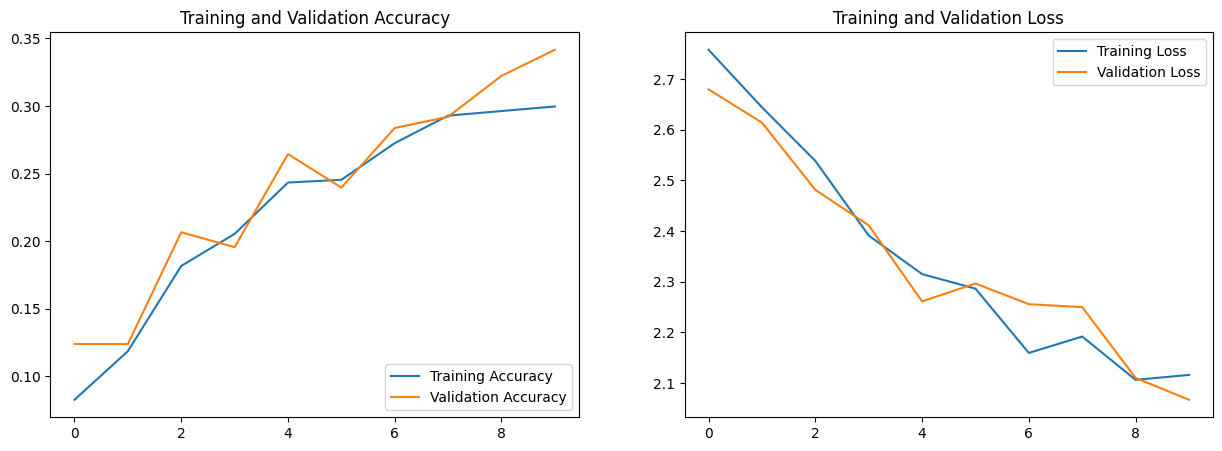

In [9]:
# Plot accuracy and loss over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}".format(test_accuracy))

predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=-1)

cm = confusion_matrix(test_dataset.labels, y_pred)
print("Confusion Matrix:")
print(cm)

cr = classification_report(test_dataset.labels,y_pred,target_names=class_labels.values())
print("Classification Report:")
print(cr)

15/15 [==============================] - 5s 337ms/step - loss: 2.1012 - accuracy: 0.3250
Test loss: 2.10
Test accuracy: 0.32
15/15 [==============================] - 6s 381ms/step
Confusion Matrix:
[[ 8  2  0  0  5  2  4  3  0  0  1  1  0  1  2  1]
 [ 1 14  0  1  4  2  0  0  0  0  0  0  0  1  0  7]
 [ 2  0  4  0  0  1  0  0  9  2  2  0  3  2  5  0]
 [ 2 10  1  2  0  3  1  1  1  2  2  0  0  1  1  3]
 [ 4  1  0  0 16  7  0  0  0  0  1  0  0  0  0  1]
 [ 3  2  0  0  8 14  0  0  0  0  0  2  0  0  0  1]
 [ 4  3  1  0  2  0  6  1  0  5  1  1  2  1  3  0]
 [ 9  0  0  0  3  0  4 10  0  0  1  2  1  0  0  0]
 [ 0  2  3  1  0  0  2  0 12  0  5  0  0  3  2  0]
 [ 3  0  0  0  4  0  5  3  0 10  0  0  1  1  2  1]
 [ 1  2  7  0  3  0  0  0  3  1  8  1  0  0  4  0]
 [ 0  0  3  1  2  2  1  0  4  3  0  9  5  0  0  0]
 [ 1  2  1  1  0  1  4  1  0  6  5  1  1  4  2  0]
 [ 4  0  0  0  2  1  0  0  3  1  2  0  3 11  2  1]
 [ 5  1  1  0  2  1  1  2  6  1  0  1  0  4  5  0]
 [ 0  8  0  0  3  0  0  0  0  0  0  0

1/1 [==============================] - 0s 95ms/step


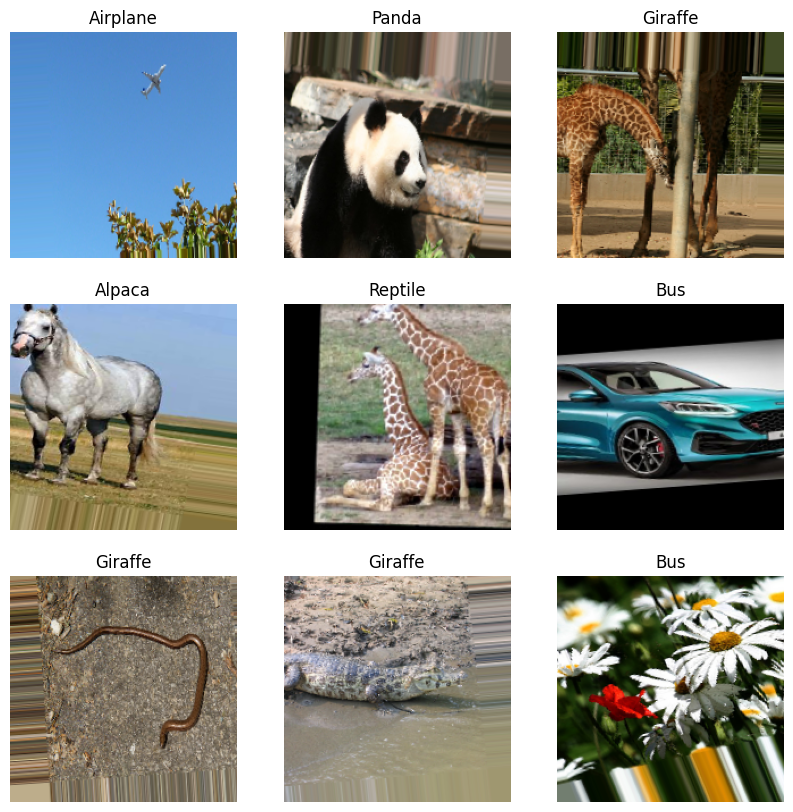

In [11]:
# Select 9 random images and their labels from the test dataset
random_indices = random.sample(range(test_dataset.n), 9)
random_images = np.array([test_dataset[i // test_dataset.batch_size][0][i % test_dataset.batch_size] for i in random_indices])
random_labels = np.array([test_dataset[i // test_dataset.batch_size][1][i % test_dataset.batch_size] for i in random_indices])

# Use the model to predict the class labels for the selected images
random_predictions = model.predict(random_images)
predicted_labels = np.argmax(random_predictions, axis=-1)

# Display the predicted class labels along with the images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(random_images[i])
    plt.title(class_labels[predicted_labels[i]])
    plt.axis("off")

plt.show()


# Modify the output sample file and save it to a .csv file

## Rename the image names in Test dataset

In [12]:
# Read the CSV file and create the output DataFrame
image_sample_df = pd.read_csv("image_sample_output.csv")
output_df = image_sample_df.copy()

def read_image_by_id(image_id, folder, extensions, labels):
    for label in labels:
        for ext in extensions:
            image_path = os.path.join(folder, label, f"{image_id}.{ext}")
            # print(image_path)
            if os.path.exists(image_path):
                return cv2.imread(image_path)
    return None

# Supported extensions
extensions = ['jpg', 'jpeg', 'png']
labels = list(class_labels.values())

for index, row in image_sample_df.iterrows():
    # Read the image using its ID, try different extensions and subfolders
    image = read_image_by_id(row['Id'], test, extensions, labels)
    if image is None:
        print(f"Image not found for ID: {row['Id']}")
        continue

    # Preprocess the image
    image = cv2.resize(image, (img_size, img_size))
    image = image / 255.0

    # Predict the label using the model
    prediction = model.predict(np.expand_dims(image, axis=0))
    predicted_label = np.argmax(prediction, axis=-1)

    # Update the "Class" column in the output dataframe with the label number
    output_df.loc[index, 'Class'] = predicted_label[0] + 1

# Save the updated dataframe to a new CSV file
output_df.to_csv("project_image_nghianguyen_cnn.csv", index=False)


1/1 [==============================] - 0s 14ms/step
